<style>
img {
    width: 720px; /* 可以按需修改宽度值 */
    height: auto; /* 保持图片比例，高度自动调整 */
    vertical-align: top; /* 设置图片上对齐 */
}
</style>
# 1. 获取期货数据

这部分内容，需要借助点宽平台，下图为获取中的状态截图

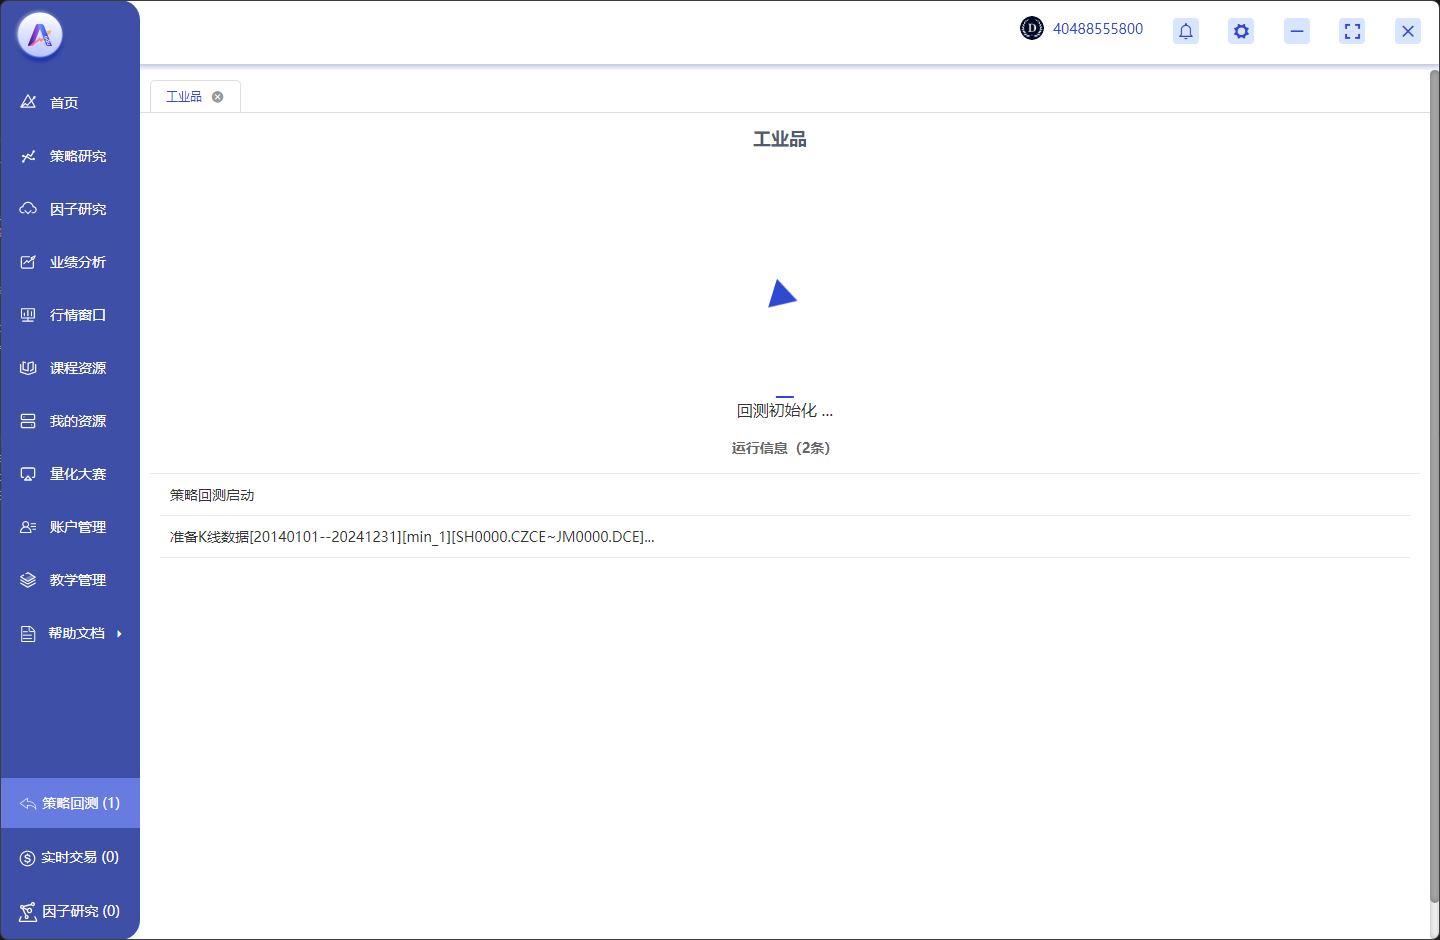

In [ ]:
"""
一、工具包导入
"""
from atrader import *
import numpy as np
import talib
from datetime import datetime, time

"""
二、初始化，仅运行一次
"""

def init(context):
    # 注册数据
    reg_kdata('min', 20)  # 注册日频行情数据
    # 回测细节设置
    context.init_cash = 10000000
    set_backtest(initial_cash=context.init_cash, future_cost_fee=1.0, stock_cost_fee=2.5,
                 margin_rate=1.0, slide_price=0, price_loc=1, deal_type=0, limit_type=0)  # 初始化设置账户总资金
    # 全局变量定义/参数定义
    context.custom_index = {}

"""
三、策略运行逻辑函数，循环运行
"""
# 1、数据（行情/仓位）—— 2、计算逻辑(指标) —— 3、下单交易（无持仓/持多单/持空单）

def on_data(context):
    ### 1、获取数据
    ##  全部行情数据获取
    data = get_reg_kdata(reg_idx=context.reg_kdata[0], fill_up=True, df=True)
    oi = data.open_interest  # 所有标的的K线行情数据
    volume = data.volume
    if data['close'].isna().any():  # 行情数据若存在nan值，则跳过
        return

    factors = pd.DataFrame({'持仓量': oi.values, '成交量': volume.values})    
    composite_factor = factors.mul(1/(factors.shape[1])).sum(axis=1)
    #print(len(composite_factor))
    # 标准化分数，使总和为1
    total_score = sum(dict(composite_factor).values())
    weights = {species: score / total_score for species, score in composite_factor.items()}

    # 获取收盘价，并转为ndarray类型的二维数组
    close = data.close 
    # np.savetxt('close.csv', close, delimiter=',')

    # 计算加权平均价格
    li= [30,10,10,50,10,5,10,25,100,10,20,20,10,25,50,20,10,10,10,5,5,10,25,20,5,10,10,10,25,10,20,25,50,20,20,30]
    # li=[10,10,10,10,20,10,10,25,10,25,90,20,10,10,10]
    weighted_sum = sum([(close[i]/li[i] )* weights[composite_factor.index[i]] for i in range(len(composite_factor.index))])
    total_weight = sum(weights.values())

    # 计算自定义商品指数
    custom_index = weighted_sum / total_weight
    # 使用 date() 方法来提取日期部分
    time = context.now.date()
    context.custom_index[time] = [custom_index]

    custom_index = pd.DataFrame(context.custom_index).T
    custom_index.columns = ['close']
    custom_index.to_csv('source/工业品2014-2014.csv')
"""
四、策略执行脚本
"""
if __name__ == '__main__':
#     ncp = ['czce.oi0000','dce.c0000','dce.a0000','czce.pk0000','dce.y0000','czce.rm0000','dce.m0000',
#  'czce.cf0000','dce.cs0000','czce.cj0000','dce.lh0000','dce.p0000','czce.sr0000','dce.jd0000','czce.ap0000']
    gyp =['czce.sh0000','czce.sm0000','shfe.fu0000','ine.nr0000','shfe.bu0000','dce.eb0000','ine.lu0000','shfe.br0000',
    'ine.sc0000','czce.sf0000','czce.ur0000','dce.pg0000','czce.ma0000','shfe.zn0000','dce.i0000','czce.sa0000','shfe.ni0000',
    'czce.px0000','czce.ta0000','dce.l0000','dce.pp0000','shfe.sn0000','shfe.pb0000','czce.fg0000','dce.v0000','shfe.hc0000',
    'czce.pf0000','dce.eg0000','gfex.si0000','shfe.rb0000','gfex.lc0000','shfe.ss0000','czce.cj0000','shfe.ao0000','shfe.sp0000','dce.jm0000']
    # 策略回测函数
    # run_backtest(strategy_name='多空数量', file_path='.', target_list=code_list,
    #              frequency='min', fre_num=120, begin_date='2019-10-01', end_date='2024-11-08', fq=1)

    run_backtest(strategy_name='工业品', file_path='.', target_list=gyp,
                 frequency='min', fre_num=20, begin_date='2014-01-01', end_date='2024-12-31', fq=1)


# 2. 数据预处理

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.svm import SVR
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import randint
import math
import gc 
from collections import deque 
import random 
from datetime import datetime
from arch import arch_model


# 检查 GPU 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

Using device: cuda


## 2.1 TVK-means聚类

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 曲率关键点提取函数
def extract_key_points(price_vector, key_ratio=0.2):
    n = len(price_vector)
    if n < 3:
        return np.arange(n), price_vector
    diff1 = np.diff(price_vector)
    diff2 = np.diff(diff1)
    curvature = np.abs(diff2)
    curvature = np.concatenate([[0], curvature, [0]])  # 首尾补0
    valid_indices = np.arange(1, n-1)
    sorted_valid_indices = valid_indices[np.argsort(-curvature[valid_indices])]
    num_key = max(2, int(len(valid_indices) * key_ratio))
    key_indices = sorted_valid_indices[:num_key]
    key_indices_sorted = np.sort(key_indices)
    return key_indices_sorted, price_vector[key_indices_sorted]

# TVKMeans类（加入平滑约束）
class TVKMeans(KMeans):
    def __init__(self, n_clusters=8, lambda_=0.1, max_iter=300, **kwargs):
        self.lambda_ = lambda_
        super().__init__(n_clusters=n_clusters, max_iter=max_iter, **kwargs)
    
    def _update_centroids(self, X, labels):
        centroids = super()._update_centroids(X, labels)
        if self.n_clusters >= 2:
            sorted_indices = np.argsort(centroids[:, 0])
            sorted_centroids = centroids[sorted_indices]
            tv_penalty = np.sum(np.diff(sorted_centroids, axis=0) ** 2)
            smoothed_centroids = sorted_centroids - self.lambda_ * tv_penalty
            centroids = smoothed_centroids[np.argsort(sorted_indices)]
        return centroids

# 聚类流程函数
def process_and_cluster(df, T_values, k_values, key_ratio=0.2, target_length=10):
    cluster_labels_dict = {}
    for T, k in zip(T_values, k_values):
        price_windows = [df['close'].iloc[i:i+T].values for i in range(len(df)-T+1)]
        key_vectors = []
        for window in price_windows:
            key_indices, key_prices = extract_key_points(window, key_ratio)
            if len(key_prices) < target_length:
                x = key_indices
                x_new = np.linspace(x.min(), x.max(), target_length)
                key_prices = np.interp(x_new, x, key_prices)
            key_vectors.append(key_prices)
        scaler = StandardScaler()
        key_vectors_scaled = scaler.fit_transform(key_vectors)
        kmeans = TVKMeans(n_clusters=k, lambda_=0.1, random_state=42)
        cluster_labels = kmeans.fit_predict(key_vectors_scaled)
        col_name = f'Cluster_T{T}_K{k}'
        df[col_name] = np.nan
        df.iloc[:len(cluster_labels), df.columns.get_loc(col_name)] = cluster_labels
    return df


if __name__ == "__main__":
    df = pd.read_csv('source/工业品2014-2024.csv')
    T_values = [5, 10, 30, 50]
    k_values = [3, 6, 9, 12]
    df = process_and_cluster(df, T_values, k_values, key_ratio=0.2, target_length=10)
    df.to_csv('source/工业品指数聚类结果.csv', index=False)
    print("聚类完成，结果已保存至 '工业品指数_聚类结果.csv'")
    

聚类完成，结果已保存至 '工业品指数_聚类结果.csv'


## 2.2 标准化+划分数据集

In [ ]:
# 读取数据
data = pd.read_csv('source/工业品指数_聚类结果.csv')

# 提取日期列
dates = pd.to_datetime(data['date']) 
net_df = data[['open', 'close', 'high', 'low', 'volume']]

# 数据预处理
data.fillna(method='ffill', inplace=True)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['open', 'close', 'high', 'low', 'volume']])
cluster_labels = data[['Cluster_Label_T5_K3', 'Cluster_Label_T10_K6', 'Cluster_Label_T30_K9', 'Cluster_Label_T50_K12']]
features = np.hstack((scaled_data, cluster_labels))

# 创建时间序列数据集
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7
X, y = create_dataset(features, features[:, 1], time_steps)

# 按时间顺序划分数据集
test_size = int(len(X) * 0.1)
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# 提取测试集对应的真实日期
test_dates = dates[time_steps + len(X_train):time_steps + len(X_train) + len(X_test)]

# 转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

C:\Users\songz\AppData\Local\Temp\ipykernel_29192\2644940080.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
d:\Anaconda3\envs\Pytorch\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
d:\Anaconda3\envs\Pytorch\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\Anaconda3\envs\Pytorch\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or 

# 3. Transformer+SVR模型构建和模型训练

训练单层 Transformer...
Epoch 0, Loss: 0.1014
Epoch 10, Loss: 0.0108
Epoch 20, Loss: 0.0059
Epoch 30, Loss: 0.0047
Epoch 40, Loss: 0.0045
Epoch 50, Loss: 0.0043
Epoch 60, Loss: 0.0041
Epoch 70, Loss: 0.0037
Epoch 80, Loss: 0.0038
Epoch 90, Loss: 0.0036
Epoch 100, Loss: 0.0034
Epoch 110, Loss: 0.0033
Epoch 120, Loss: 0.0033
Epoch 130, Loss: 0.0033
Epoch 140, Loss: 0.0032
Epoch 150, Loss: 0.0031
Epoch 160, Loss: 0.0031
Epoch 170, Loss: 0.0031
Epoch 180, Loss: 0.0030
Epoch 190, Loss: 0.0029


C:\Users\songz\AppData\Local\Temp\ipykernel_17832\62584826.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(X_train[start:end], dtype=torch.float32).to(device)
C:\Users\songz\AppData\Local\Temp\ipykernel_17832\62584826.py:187: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(y_train[start:end], dtype=torch.float32).to(device)


Epoch 0, Loss: 0.0387
Epoch 10, Loss: 0.0059
Epoch 20, Loss: 0.0045
Epoch 30, Loss: 0.0041
Epoch 40, Loss: 0.0038
Epoch 50, Loss: 0.0037
Epoch 60, Loss: 0.0036
Epoch 70, Loss: 0.0035
Epoch 80, Loss: 0.0033
Epoch 90, Loss: 0.0034
Epoch 100, Loss: 0.0032
Epoch 110, Loss: 0.0031
Epoch 120, Loss: 0.0031
Epoch 130, Loss: 0.0031
Epoch 140, Loss: 0.0031
Epoch 150, Loss: 0.0030
Epoch 160, Loss: 0.0030
Epoch 170, Loss: 0.0029
Epoch 180, Loss: 0.0030
Epoch 190, Loss: 0.0030
Epoch 0, Loss: 0.1135
Epoch 10, Loss: 0.0087
Epoch 20, Loss: 0.0055
Epoch 30, Loss: 0.0048
Epoch 40, Loss: 0.0042
Epoch 50, Loss: 0.0043
Epoch 60, Loss: 0.0038
Epoch 70, Loss: 0.0037
Epoch 80, Loss: 0.0036
Epoch 90, Loss: 0.0035
Epoch 100, Loss: 0.0033
Epoch 110, Loss: 0.0034
Epoch 120, Loss: 0.0031
Epoch 130, Loss: 0.0031
Epoch 140, Loss: 0.0031
Epoch 150, Loss: 0.0029
Epoch 160, Loss: 0.0030
Epoch 170, Loss: 0.0029
Epoch 180, Loss: 0.0028
Epoch 190, Loss: 0.0029
训练多层 Transformer...
Epoch 0, Loss: 0.0383
Epoch 10, Loss: 0.00

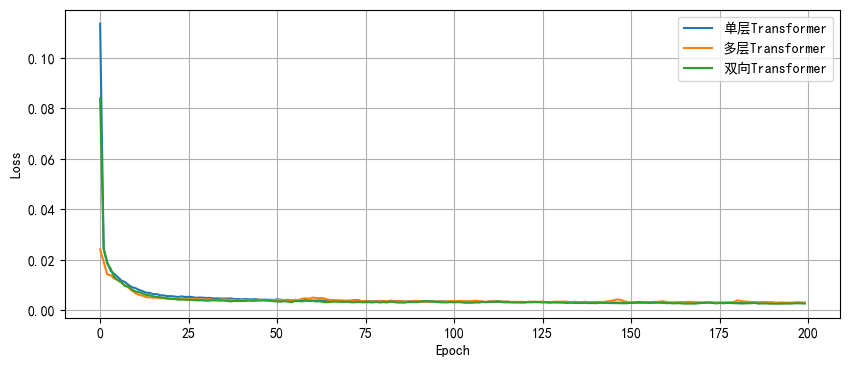

In [ ]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import random
import gc
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# 定义 Transformer 块
class TransformerBlock(nn.Module):
    def __init__(self, input_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.self_attn = nn.MultiheadAttention(input_dim, num_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(input_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, input_dim)
        )
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.self_attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

# 单层 Transformer
class SingleTransformer(nn.Module):
    def __init__(self, input_dim, num_heads, ff_dim, dropout=0.1):
        super(SingleTransformer, self).__init__()
        self.transformer_block = TransformerBlock(input_dim, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = self.transformer_block(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x.squeeze(-1)

# 多层 Transformer
class MultiLayerTransformer(nn.Module):
    def __init__(self, input_dim, num_heads, ff_dim, num_layers=2, dropout=0.1):
        super(MultiLayerTransformer, self).__init__()
        self.transformer_layers = nn.ModuleList([
            TransformerBlock(input_dim, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        for layer in self.transformer_layers:
            x = layer(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x.squeeze(-1)

# 双向 Transformer
class BidirectionalTransformer(nn.Module):
    def __init__(self, input_dim, num_heads, ff_dim, dropout=0.1):
        super(BidirectionalTransformer, self).__init__()
        self.forward_transformer = TransformerBlock(input_dim, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
        self.backward_transformer = TransformerBlock(input_dim, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
        self.fc = nn.Linear(2 * input_dim, 1)

    def forward(self, x):
        forward_output = self.forward_transformer(x)
        backward_output = self.backward_transformer(x.flip(1))
        combined_output = torch.cat([forward_output[:, -1, :], backward_output[:, -1, :]], dim=-1)
        x = self.fc(combined_output)
        return x.squeeze(-1)

# 添加损失记录并返回模型和损失列表
def train_pytorch_model(model, X_train, y_train, epochs=200, batch_size=32, lr=0.0016):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    num_batches = math.ceil(len(X_train) / batch_size)
    losses = []  # 记录每个 epoch 的损失
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for i in range(num_batches):
            start = i * batch_size
            end = min(start + batch_size, len(X_train))
            inputs = X_train[start:end].clone().detach().to(device)
            targets = y_train[start:end].clone().detach().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            del inputs, targets, outputs, loss
            torch.cuda.empty_cache()
        epoch_loss = total_loss / num_batches
        losses.append(epoch_loss)  # 保存当前 epoch 损失
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {epoch_loss:.4f}')
    return model, losses  # 返回模型和损失列表

# 网格搜索调参 Pytorch 模型
def grid_search_pytorch(model_class, X_train, y_train):
    param_grid = {
        'num_heads': [1, 2],
        'ff_dim': [32, 64]
    }
    best_score = -np.inf
    best_params = None
    embed_dim = X_train.shape[2]
    for num_heads in param_grid['num_heads']:
        for ff_dim in param_grid['ff_dim']:
            if embed_dim % num_heads != 0:
                continue
            model = model_class(X_train.shape[2], num_heads=num_heads, ff_dim=ff_dim, dropout=0.1)
            model, _ = train_pytorch_model(model, X_train, y_train)  # 忽略损失
            all_outputs = []
            all_losses = []
            num_batches = math.ceil(len(X_train) / 16)
            with torch.no_grad():
                for i in range(num_batches):
                    start = i * 16
                    end = min(start + 16, len(X_train))
                    inputs = torch.tensor(X_train[start:end], dtype=torch.float32).to(device)
                    targets = torch.tensor(y_train[start:end], dtype=torch.float32).to(device)
                    outputs = model(inputs)
                    loss = nn.MSELoss()(outputs, targets)
                    all_outputs.extend(outputs.cpu().tolist())
                    all_losses.append(loss.item())
                    del inputs, targets, outputs, loss
                    torch.cuda.empty_cache()
            score = -np.mean(all_losses)
            if score > best_score:
                best_score = score
                best_params = {'num_heads': num_heads, 'ff_dim': ff_dim}
            gc.collect()
    return best_params

# 网格搜索调参 SVR 模型
def grid_search_svr(X_train, y_train):
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1]
    }
    svr = SVR(kernel='rbf')
    grid_search = GridSearchCV(svr, param_grid, cv=3)
    svr_X_train = X_train.reshape(X_train.shape[0], -1)
    grid_search.fit(svr_X_train, y_train)
    return grid_search.best_params_

# 训练单层 Transformer
print("训练单层 Transformer...")
single_best_params = grid_search_pytorch(SingleTransformer, X_train, y_train)
single_transformer = SingleTransformer(X_train.shape[2], **single_best_params, dropout=0.1)
single_transformer, single_losses = train_pytorch_model(single_transformer, X_train, y_train)

# 训练多层 Transformer
print("训练多层 Transformer...")
multi_best_params = grid_search_pytorch(MultiLayerTransformer, X_train, y_train)
multi_layer_transformer = MultiLayerTransformer(X_train.shape[2], **multi_best_params, num_layers=2, dropout=0.1)
multi_layer_transformer, multi_losses = train_pytorch_model(multi_layer_transformer, X_train, y_train)

# 训练双向 Transformer
print("训练双向 Transformer...")
bi_best_params = grid_search_pytorch(BidirectionalTransformer, X_train, y_train)
bidirectional_transformer = BidirectionalTransformer(X_train.shape[2], **bi_best_params, dropout=0.1)
bidirectional_transformer, bi_losses = train_pytorch_model(bidirectional_transformer, X_train, y_train)

# 训练 SVR 模型
print("训练 SVR 模型...")
svr_best_params = grid_search_svr(X_train, y_train)
svr = SVR(kernel='rbf', **svr_best_params)
svr_X_train = X_train.reshape(X_train.shape[0], -1)
svr.fit(svr_X_train, y_train)

# 绘制损失曲线
plt.figure(figsize=(10, 4))
plt.plot(single_losses, label='单层Transformer')
plt.plot(multi_losses, label='多层Transformer')
plt.plot(bi_losses, label='双向Transformer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 4. 模型预测

In [ ]:
import torch
import numpy as np
import math
import csv


# 定义预测和导出结果的函数
def predict_and_export(model, X_test, test_dates, file_name, prediction_name):
    all_pred = []
    num_batches = math.ceil(len(X_test) / 16)
    with torch.no_grad():
        for i in range(num_batches):
            start = i * 16
            end = min(start + 16, len(X_test))
            inputs = torch.tensor(X_test[start:end], dtype=torch.float32).to(device)
            if isinstance(model, torch.nn.Module):  # 检查是否是 PyTorch 模型
                outputs = model(inputs)
                all_pred.extend(outputs.cpu().tolist())
            else:  # 处理 SVR 模型的情况
                # 直接将 X_test 调整为二维数组
                svr_inputs = X_test[start:end].reshape(end - start, -1)
                outputs = model.predict(svr_inputs)
                all_pred.extend(outputs.tolist())
            del inputs, outputs
            torch.cuda.empty_cache()
    pred = np.array(all_pred)

    try:
        with open(file_name, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Date', prediction_name])
            for date, prediction in zip(test_dates, pred):
                writer.writerow([date, prediction])
    except IOError as e:
        print(f"文件写入错误: {e}")


# 单层 Transformer 预测
print("单层 Transformer 预测...")
predict_and_export(single_transformer, X_test, test_dates,
                   'source/单层Transformer预测结果.csv', 'Single Transformer Prediction')

# 多层 Transformer 预测
print("多层 Transformer 预测...")
predict_and_export(multi_layer_transformer, X_test, test_dates,
                   'source/多层Transformer预测结果.csv', 'Multi-layer Transformer Prediction')

# 双向 Transformer 预测
print("双向 Transformer 预测...")
predict_and_export(bidirectional_transformer, X_test, test_dates,
                   'source/双向Transformer预测结果.csv', 'Bidirectional Transformer Prediction')

# SVR 预测
print("SVR 预测...")
predict_and_export(svr, X_test, test_dates,
                   'source/SVR预测结果.csv', 'SVR Prediction')

单层 Transformer 预测...
多层 Transformer 预测...
双向 Transformer 预测...
SVR 预测...


C:\Users\songz\AppData\Local\Temp\ipykernel_17832\4075600593.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(X_test[start:end], dtype=torch.float32).to(device)
C:\Users\songz\AppData\Local\Temp\ipykernel_17832\4075600593.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(X_test[start:end], dtype=torch.float32).to(device)
C:\Users\songz\AppData\Local\Temp\ipykernel_17832\4075600593.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(X_test[start:end], dtype=torch.flo

# 5. 强化学习集成+预测 可视化展示

强化学习集成...
生成预测结果...

=== 预测结果保存成功 ===
数据示例：
         date  DQN_Prediction  actual_price
0  2023-11-28     1030.344557   1053.415127
1  2023-11-29     1059.815326   1089.622532
2  2023-11-30     1066.352468   1052.478610
3  2023-12-01     1070.095976   1093.749110
4  2023-12-04     1080.580039   1079.219418

列说明：
DQN_Prediction: 智能体选择的预测收盘价（逆变换后）
actual_price: 对应日期的真实收盘价（逆变换后）


C:\Users\songz\AppData\Local\Temp\ipykernel_29192\1791979793.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(selected_preds, torch.tensor(y_test, dtype=torch.float32))



Evaluation Metrics (Test Set - After Inverse Transformation):
Agent Selection - RMSE: 0.0379, MSE: 0.0014, R^2: 0.86, MAE: 0.0265
SVR - RMSE: 0.05, MSE: 0.0025, R^2: 0.76, MAE: 0.0356
单层Transformer - RMSE: 0.0430, MSE: 0.0019, R^2: 0.82, MAE: 0.0311
多层Transformer - RMSE: 0.0423, MSE: 0.0018, R^2: 0.83, MAE: 0.0306
双向Transformer - RMSE: 0.0482, MSE: 0.0023, R^2: 0.78, MAE: 0.0350


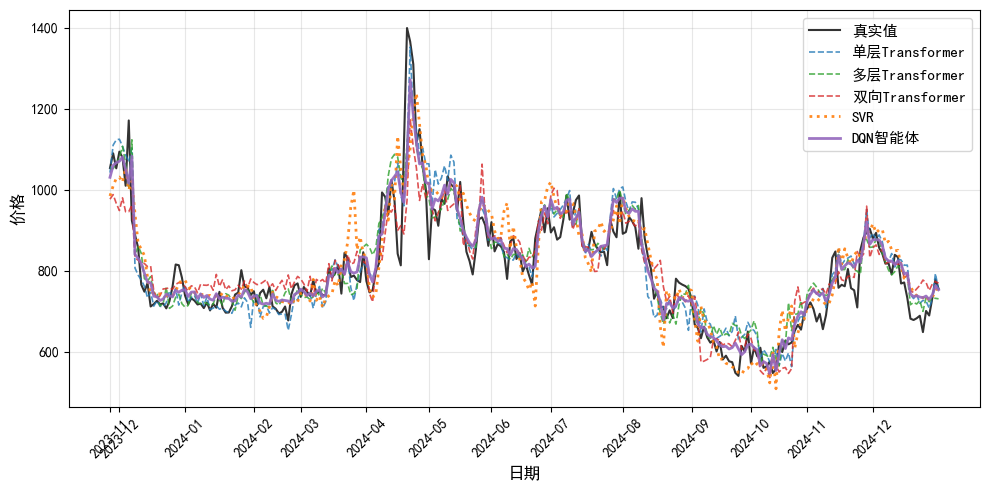

In [ ]:
import torch
import numpy as np
import math
import csv
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import deque
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch.nn as nn
import torch.optim as optim
from datetime import datetime

# 导入 CSV 文件中的预测结果
single_transformer_pred_df = pd.read_csv('source/单层Transformer预测结果.csv')
single_pred = single_transformer_pred_df['Single Transformer Prediction'].values
test_dates = pd.to_datetime(single_transformer_pred_df['Date']).dt.strftime("%Y-%m-%d")

multi_layer_transformer_pred_df = pd.read_csv('source/多层Transformer预测结果.csv')
multi_pred = multi_layer_transformer_pred_df['Multi-layer Transformer Prediction'].values

bidirectional_transformer_pred_df = pd.read_csv('source/双向Transformer预测结果.csv')
bi_pred = bidirectional_transformer_pred_df['Bidirectional Transformer Prediction'].values

svr_pred_df = pd.read_csv('source/SVR预测结果.csv')
svr_pred = svr_pred_df['SVR Prediction'].values

# 定义一个辅助函数来处理字符串转换
def convert_to_float(val):
    if isinstance(val, str):
        # 去掉方括号和多余空格
        val = val.strip('[]').strip()
        return float(val)
    return val

single_pred = np.array([convert_to_float(val) for val in single_pred])
multi_pred = np.array([convert_to_float(val) for val in multi_pred])
bi_pred = np.array([convert_to_float(val) for val in bi_pred])
svr_pred = np.array([convert_to_float(val) for val in svr_pred])

# 强化学习集成
print("强化学习集成...")
state_size = 4  # 四个模型的预测结果
action_size = 4  # 0: SVR, 1: 单层 Transformer, 2: 多层 Transformer, 3: 双向 Transformer


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, self.action_size)
        )
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model(torch.tensor(state, dtype=torch.float32))
        action = np.argmax(act_values.detach().numpy())
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            # 检查并转换 next_state 中的字符串类型数据为数值类型
            new_next_state = []
            for val in next_state.flatten():
                if isinstance(val, str):
                    val = val.strip('[]')  # 去掉方括号
                    val = float(val.strip())  # 去掉可能的空格并转换为浮点数
                new_next_state.append(val)
            next_state = np.array(new_next_state).reshape(1, self.state_size)

            new_state = []
            for val in state.flatten():
                if isinstance(val, str):
                    val = val.strip('[]')  # 去掉方括号
                    val = float(val.strip())  # 去掉可能的空格并转换为浮点数
                new_state.append(val)
            state = np.array(new_state).reshape(1, self.state_size)

            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model(torch.tensor(next_state, dtype=torch.float32)).detach().numpy()))
            target_f = self.model(torch.tensor(state, dtype=torch.float32))
            target_f[0][action] = target


agent = DQNAgent(state_size, action_size)
batch_size = 32
episodes = 300
for e in range(episodes):
    state = np.array([svr_pred[0], single_pred[0], multi_pred[0], bi_pred[0]]).reshape(1, state_size)
    for t in range(len(y_test) - 1):
        action = agent.act(state)
        if action == 0:
            pred = svr_pred[t]
        elif action == 1:
            pred = single_pred[t]
        elif action == 2:
            pred = multi_pred[t]
        else:
            pred = bi_pred[t]

        # 检查并处理 pred 的类型
        if isinstance(pred, str):
            pred = pred.strip('[]')  # 去掉方括号
            pred = float(pred.strip())  # 去掉可能的空格并转换为浮点数

        # 确保 y_test[t] 是合适的类型
        y_test_value = y_test[t].item() if isinstance(y_test[t], torch.Tensor) else y_test[t]

        reward = -np.abs(pred - y_test_value)
        next_state = np.array([svr_pred[t + 1], single_pred[t + 1], multi_pred[t + 1], bi_pred[t + 1]]).reshape(1,
                                                                                                                  state_size)
        done = t == len(y_test) - 2
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)


# 定义逆变换函数
def inverse_transform_pred(pred):
    return scaler.inverse_transform(
        np.concatenate((pred.reshape(-1, 1), np.zeros((len(pred), 4))), axis=1)
    )[:, 0]


print("生成预测结果...")


# 强化学习智能体
class RLAgent(nn.Module):
    def __init__(self, num_models):
        super(RLAgent, self).__init__()
        self.fc1 = nn.Linear(num_models, 16)
        self.fc2 = nn.Linear(16, num_models)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        return x


num_models = 4
agent = RLAgent(num_models)
optimizer = optim.Adam(agent.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 训练智能体
epochs = 500
for epoch in range(epochs):
    all_preds = np.stack([single_pred, multi_pred, bi_pred, svr_pred], axis=1)
    all_preds = torch.tensor(all_preds, dtype=torch.float32)
    actions = agent(all_preds)
    selected_preds = (actions * all_preds).sum(dim=1)
    loss = criterion(selected_preds, torch.tensor(y_test, dtype=torch.float32))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 使用智能体选择预测结果
with torch.no_grad():
    all_preds = np.stack([single_pred, multi_pred, bi_pred, svr_pred], axis=1)
    all_preds = torch.tensor(all_preds, dtype=torch.float32)
    actions = agent(all_preds)
    selected_preds = (actions * all_preds).sum(dim=1).numpy()


# 逆变换结果
y_test_inverse = inverse_transform_pred(y_test.numpy())
single_pred_inverse = inverse_transform_pred(single_pred)
multi_pred_inverse = inverse_transform_pred(multi_pred)
bi_pred_inverse = inverse_transform_pred(bi_pred)
svr_pred_inverse = inverse_transform_pred(svr_pred)
selected_preds_inverse = inverse_transform_pred(selected_preds)

# 创建包含智能体预测价格和对应日期真实价格的 DataFrame
data = {
    'date': test_dates,
    'DQN_Prediction': selected_preds_inverse,
    'actual_price': y_test_inverse
}
prediction_df = pd.DataFrame(data)

# 标准化日期格式（确保兼容 Excel）
prediction_df['date'] = pd.to_datetime(prediction_df['date']).dt.strftime("%Y-%m-%d")

# 生成带时间戳的文件名
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f"source/智能体集成预测结果.csv"
# 保存文件
prediction_df.to_csv(file_name, index=False)

# 输出验证
print("\n=== 预测结果保存成功 ===")
print("数据示例：")
print(prediction_df.head())
print("\n列说明：")
print("DQN_Prediction: 智能体选择的预测收盘价（逆变换后）")
print("actual_price: 对应日期的真实收盘价（逆变换后）")


# 计算各模型评估指标
rmse_single = np.sqrt(mean_squared_error(y_test, single_pred))
mse_single = mean_squared_error(y_test, single_pred)
r2_single = r2_score(y_test, single_pred)
mae_single = mean_absolute_error(y_test, single_pred)

rmse_multi = np.sqrt(mean_squared_error(y_test, multi_pred))
mse_multi= mean_squared_error(y_test, multi_pred)
r2_multi = r2_score(y_test, multi_pred)
mae_multi = mean_absolute_error(y_test, multi_pred)

rmse_bi = np.sqrt(mean_squared_error(y_test, bi_pred))
mse_bi = mean_squared_error(y_test, bi_pred)
r2_bi = r2_score(y_test, bi_pred)
mae_bi = mean_absolute_error(y_test, bi_pred)

rmse_svr = np.sqrt(mean_squared_error(y_test, svr_pred))
mse_svr = mean_squared_error(y_test, svr_pred)
r2_svr = r2_score(y_test, svr_pred)
mae_svr = mean_absolute_error(y_test, svr_pred)

rmse_selected = np.sqrt(mean_squared_error(y_test, selected_preds))
mse_selected= mean_squared_error(y_test, selected_preds)
r2_selected = r2_score(y_test, selected_preds)
mae_selected = mean_absolute_error(y_test, selected_preds)


# 可视化对比
plt.figure(figsize=(10, 5))  

# 绘制曲线
plt.plot(test_dates, y_test_inverse, '-', color='black', linewidth=1.5, label='真实值', alpha=0.8)
plt.plot(test_dates, single_pred_inverse, '--', color='tab:blue', linewidth=1.2, label='单层Transformer', alpha=0.8)
plt.plot(test_dates, multi_pred_inverse, '--', color='tab:green', linewidth=1.2, label='多层Transformer', alpha=0.8)
plt.plot(test_dates, bi_pred_inverse, '--', color='tab:red', linewidth=1.2, label='双向Transformer', alpha=0.8)
plt.plot(test_dates, svr_pred_inverse, ':', color='tab:orange', linewidth=2.0, label='SVR', alpha=0.9)
plt.plot(test_dates, selected_preds_inverse, '-', color='tab:purple', linewidth=2.0, label='DQN智能体', alpha=0.9)

# 处理日期
unique_months = []
unique_indices = []
month_set = set()
for index, date in enumerate(pd.to_datetime(test_dates)):
    month_key = date.strftime('%Y-%m')
    if month_key not in month_set:
        unique_months.append(date.strftime('%Y-%m'))
        unique_indices.append(index)
        month_set.add(month_key)

plt.xticks(unique_indices, unique_months, rotation=45)

# 图表设置
# plt.title('Comparison of Model Prediction Results(Industrial Product Index)', fontsize=16)
plt.xlabel('日期', fontsize=12)
plt.ylabel('价格', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

print("\nEvaluation Metrics (Test Set - After Inverse Transformation):")
print(f'Agent Selection - RMSE: {rmse_selected:.4f}, MSE: {mse_selected:.4f}, R^2: {r2_selected:.2f}, MAE: {mae_selected:.4f}')
print(f'SVR - RMSE: {rmse_svr:.2f}, MSE: {mse_svr:.4f}, R^2: {r2_svr:.2f}, MAE: {mae_svr:.4f}')
print(f'单层Transformer - RMSE: {rmse_single:.4f}, MSE: {mse_single:.4f}, R^2: {r2_single:.2f}, MAE: {mae_single:.4f}')
print(f'多层Transformer - RMSE: {rmse_multi:.4f}, MSE: {mse_multi:.4f}, R^2: {r2_multi:.2f}, MAE: {mae_multi:.4f}')
print(f'双向Transformer - RMSE: {rmse_bi:.4f}, MSE: {mse_bi:.4f}, R^2: {r2_bi:.2f}, MAE: {mae_bi:.4f}')

plt.tight_layout()
plt.show()


# 6. 交易回测


Conducting moving average crossover strategy backtest...


100%|██████████| 246/246 [00:37<00:00,  6.61it/s]



Moving Average Crossover strategy backtest results:
Final capital: ¥1,974,634.84
Total return: 97.46%
Annualized return: 90.52%
Maximum drawdown: 5.41%


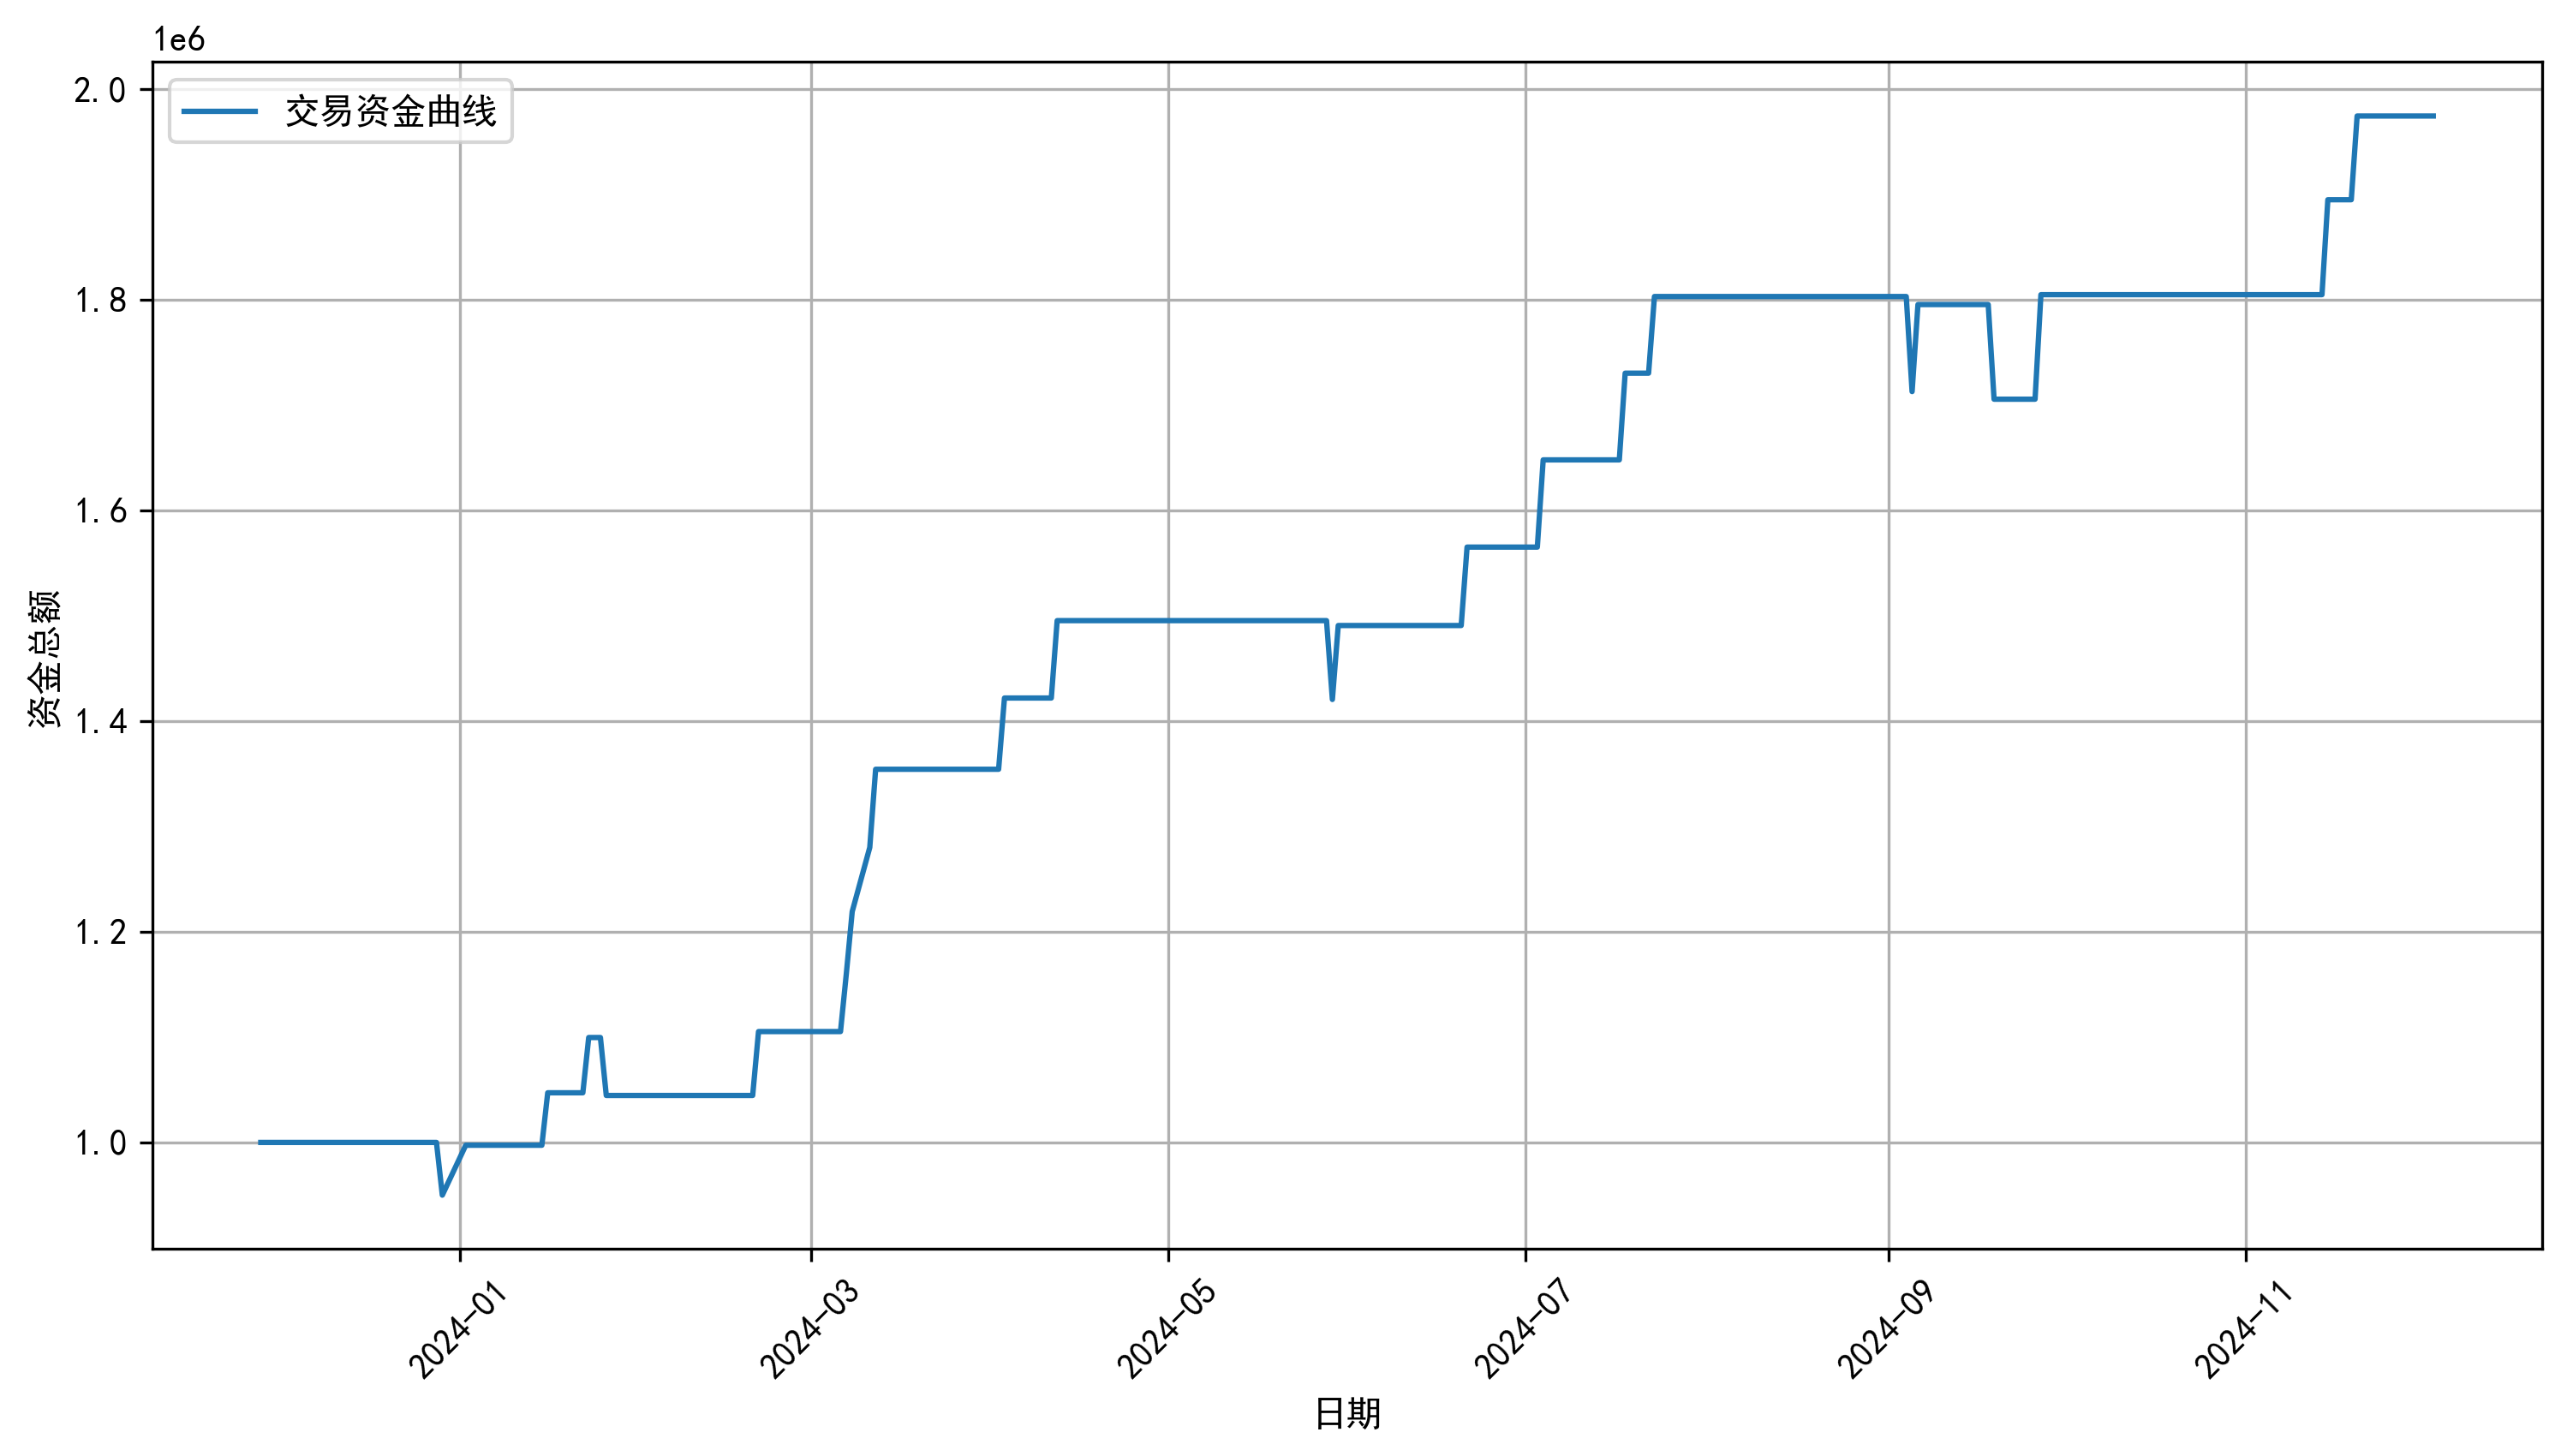

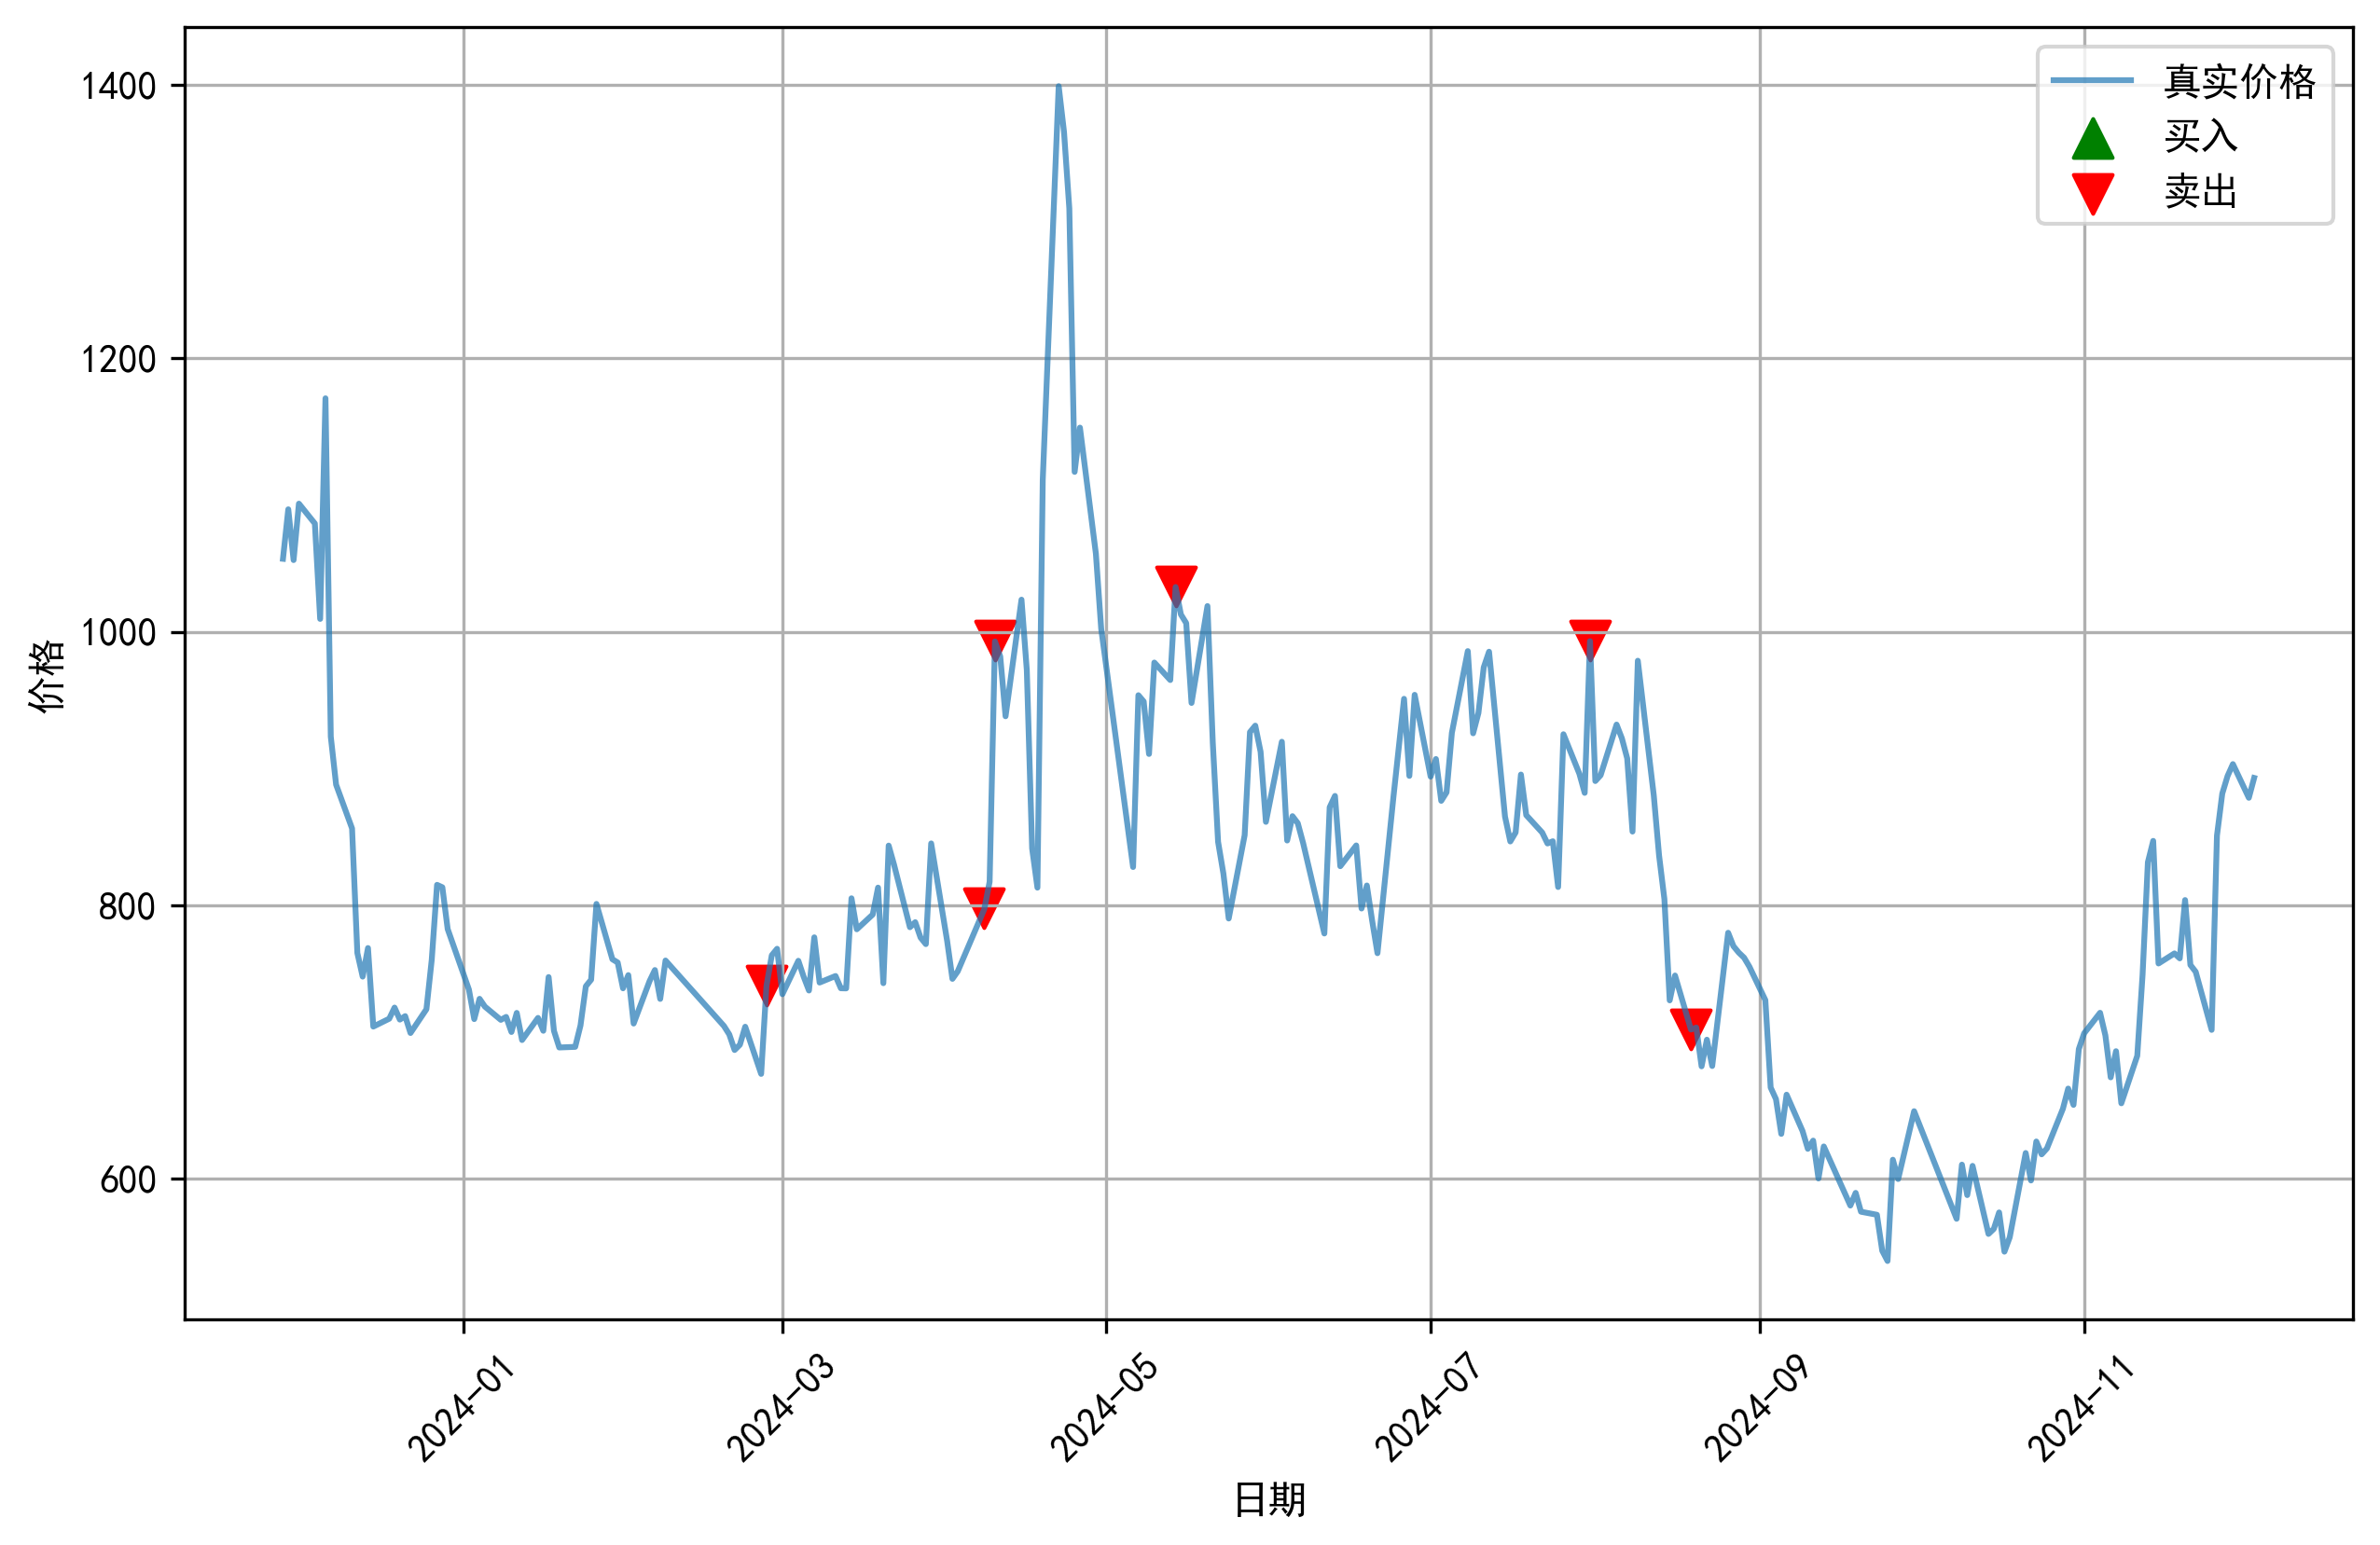

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import time

# 微信公众号相关信息
APPID = 'wx4541f54e88ef0b73'
APPSECRET = 'bcaed73d0477e8caf2871fce805cd411'
TEMPLATE_ID = 'P6tVDtHnaFLX6Q3SNh7Ctum69J_Z68acaUCY_588bHg'
OPENID = 'o5Fvz7OVtjuxpwjNEzywBP_d5t5g'


def get_access_token():
    url = f'https://api.weixin.qq.com/cgi-bin/token?grant_type=client_credential&appid={APPID}&secret={APPSECRET}'
    response = requests.get(url)
    access_token = response.json().get('access_token')
    return access_token


def send_template_message(access_token, trade_info):
    url = f'https://api.weixin.qq.com/cgi-bin/message/template/send?access_token={access_token}'
    data = {
        "touser": OPENID,
        "template_id": TEMPLATE_ID,
        "data": {
            "first": {
                "value": f"New trade occurred!",
                "color": "#173177"
            },
            "time": {
                "value": trade_info['time'],
                "color": "#173177"
            },
            "operation": {
                "value": trade_info['operation'],
                "color": "#173177"
            },
            "price": {
                "value": f"{trade_info['price']:.2f}",
                "color": "#173177"
            },
            "quantity": {
                "value": f"{trade_info['quantity']:.2f}",
                "color": "#173177"
            },
            "available_capital": {
                "value": f"{trade_info['available_capital']:.2f}",
                "color": "#173177"
            },
            "remark": {
                "value": "Please pay attention to the trading situation.",
                "color": "#173177"
            }
        }
    }
    response = requests.post(url, json=data)
    time.sleep(1)  # 每次调用后休眠 1 秒
    return response.json()


def moving_average_crossover_backtest(
        actual_prices,  # 真实价格（包含日期索引）
        strategy_name  # 策略名称
):
    initial_capital = 1000000
    capital = initial_capital
    position = 0
    transaction_cost = 0.001  # 交易费用
    slippage = 0.0005  # 滑点，假设为0.05%
    trade_log = []
    capital_trace = [initial_capital]
    stop_loss_percentage = 0.05
    take_profit_percentage = 0.1

    # 计算短期和长期移动平均线
    short_window = 5
    long_window = 20
    actual_prices_df = pd.DataFrame(actual_prices)
    # 使用第一列计算移动平均线
    actual_prices_df['short_ma'] = actual_prices_df.iloc[:, 0].rolling(window=short_window).mean()
    actual_prices_df['long_ma'] = actual_prices_df.iloc[:, 0].rolling(window=long_window).mean()

    # 提取日期序列（假设 actual_prices 是带日期索引的 Series）
    dates = actual_prices.index  # 从真实价格的索引获取日期
    actual_prices = actual_prices.values  # 提取价格值

    access_token = get_access_token()

    for i in tqdm(range(long_window, len(actual_prices))):
        actual_price = actual_prices[i]
        short_ma = actual_prices_df['short_ma'].iloc[i]
        long_ma = actual_prices_df['long_ma'].iloc[i]

        if position == 0:
            # 多头信号：短期均线向上穿过长期均线
            if short_ma > long_ma and actual_prices_df['short_ma'].iloc[i - 1] <= actual_prices_df['long_ma'].iloc[i - 1]:
                # 考虑滑点和交易费用
                buy_price = actual_price * (1 + slippage)
                shares_to_buy = capital * 0.05 / buy_price
                position = shares_to_buy
                capital -= shares_to_buy * buy_price * (1 + transaction_cost)
                trade_info = {
                    'time': dates[i].strftime('%Y-%m-%d'),
                    'operation': 'Buy',
                    'price': buy_price,
                    'quantity': shares_to_buy,
                    'available_capital': capital
                }
                trade_log.append(trade_info)
                send_template_message(access_token, trade_info)
            # 空头信号：短期均线向下穿过长期均线
            elif short_ma < long_ma and actual_prices_df['short_ma'].iloc[i - 1] >= actual_prices_df['long_ma'].iloc[i - 1]:
                # 考虑滑点和交易费用
                sell_price = actual_price * (1 - slippage)
                shares_to_sell = capital * 0.05 / sell_price
                position = -shares_to_sell
                capital += shares_to_sell * sell_price * (1 - transaction_cost)
                trade_info = {
                    'time': dates[i].strftime('%Y-%m-%d'),
                    'operation': 'Short Sell',
                    'price': sell_price,
                    'quantity': shares_to_sell,
                    'available_capital': capital
                }
                trade_log.append(trade_info)
                send_template_message(access_token, trade_info)
        else:
            # 计算持仓盈亏
            entry_price = trade_log[-1]['price']
            current_return = (actual_price / entry_price - 1) * (1 if position > 0 else -1)

            # 多头平仓
            if position > 0:
                if current_return < -stop_loss_percentage or current_return > take_profit_percentage:
                    # 考虑滑点和交易费用
                    sell_price = actual_price * (1 - slippage)
                    capital += position * sell_price * (1 - transaction_cost)
                    trade_info = {
                        'time': dates[i].strftime('%Y-%m-%d'),
                        'operation': 'Sell',
                        'price': sell_price,
                        'quantity': position,
                        'available_capital': capital
                    }
                    trade_log.append(trade_info)
                    send_template_message(access_token, trade_info)
                    position = 0
            # 空头平仓
            else:
                if current_return < -stop_loss_percentage or current_return > take_profit_percentage:
                    # 考虑滑点和交易费用
                    buy_price = actual_price * (1 + slippage)
                    capital -= position * buy_price * (1 + transaction_cost)
                    trade_info = {
                        'time': dates[i].strftime('%Y-%m-%d'),
                        'operation': 'Cover Short Position',
                        'price': buy_price,
                        'quantity': -position,
                        'available_capital': capital
                    }
                    trade_log.append(trade_info)
                    send_template_message(access_token, trade_info)
                    position = 0

        capital_trace.append(capital)

    # 处理未平仓头寸（使用最后一个日期和价格）
    if position != 0:
        close_price = actual_prices[-1]
        close_date = dates[-1]
        if position > 0:
            # 考虑滑点和交易费用
            sell_price = close_price * (1 - slippage)
            capital += position * sell_price * (1 - transaction_cost)
            trade_info = {
                'time': close_date.strftime('%Y-%m-%d'),
                'operation': 'Forced Sell',
                'price': sell_price,
                'quantity': position,
                'available_capital': capital
            }
            trade_log.append(trade_info)
            send_template_message(access_token, trade_info)
        else:
            # 考虑滑点和交易费用
            buy_price = close_price * (1 + slippage)
            capital -= position * buy_price * (1 + transaction_cost)
            trade_info = {
                'time': close_date.strftime('%Y-%m-%d'),
                'operation': 'Forced Cover Short Position',
                'price': buy_price,
                'quantity': -position,
                'available_capital': capital
            }
            trade_log.append(trade_info)
            send_template_message(access_token, trade_info)

    # 计算绩效指标
    total_return = (capital - initial_capital) / initial_capital * 100
    annualized_return = ((1 + total_return / 100) ** (252 / len(actual_prices)) - 1) * 100
    max_drawdown = 0
    peak = initial_capital
    for value in capital_trace:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak * 100
        if drawdown > max_drawdown:
            max_drawdown = drawdown

    # 输出结果
    print(f"\n{strategy_name} strategy backtest results:")
    print(f"Final capital: ¥{capital:,.2f}")
    print(f"Total return: {total_return:.2f}%")
    print(f"Annualized return: {annualized_return:.2f}%")
    print(f"Maximum drawdown: {max_drawdown:.2f}%")

    return pd.DataFrame(trade_log), capital_trace


# 从 CSV 文件中读取数据
file_name = f"source/智能体集成预测结果.csv"
df = pd.read_csv(file_name)

# 将日期列转换为 datetime 类型
df['date'] = pd.to_datetime(df['date'])

# 准备回测数据
y_test_series = pd.Series(df['actual_price'].values, index=df['date'])

# 执行回测
print("\nConducting moving average crossover strategy backtest...")
ma_trade_log, ma_capital_trace = moving_average_crossover_backtest(
    actual_prices=y_test_series,
    strategy_name='Moving Average Crossover'
)

# 确保 df 和 ma_capital_trace 的长度一致
if len(df['date']) > len(ma_capital_trace[:-1]):
    df = df.iloc[:len(ma_capital_trace[:-1])]

# 绘制带有日期的资金曲线
plt.figure(figsize=(12, 6))
plt.plot(df['date'], ma_capital_trace[:-1], label='交易资金曲线')
plt.xlabel('日期')
plt.ylabel('资金总额')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 绘制买入卖出操作图
plt.figure(figsize=(10, 6))
# 确保 buys 和 sells 中的日期与 df['date'] 匹配
buys = ma_trade_log[ma_trade_log['operation'] == '买入']
buys = buys[buys['time'].isin(df['date'].dt.strftime('%Y-%m-%d'))]
sells = ma_trade_log[ma_trade_log['operation'].isin(
    ['卖出', 'Cover Short Position', 'Forced Sell', 'Forced Cover Short Position'])]
sells = sells[sells['time'].isin(df['date'].dt.strftime('%Y-%m-%d'))]

plt.plot(df['date'], df['actual_price'], label='真实价格', alpha=0.7)
plt.scatter(buys['time'], buys['price'], marker='^', color='g', label='买入', s=100)
plt.scatter(sells['time'], sells['price'], marker='v', color='r', label='卖出', s=100)
plt.xlabel('日期')
plt.ylabel('价格')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()
    